# South Africa

CAMS PM2.5: Original resolution: 80km x 80km. Improved resolution: 10km x 10km.

Predictors used at the moment:
* DEM
* ERA5
* Land cover

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns
import matplotlib.colors as colors
from matplotlib.patches import Patch

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   load_list_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, recpolygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

C:\Users\carle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\carle\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

## Pre-processing (training data)

### CAMS

In [5]:
# Read CAMS PM2.5
cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'
cams_train_eop = load_tiffs(cams_train_dir/'PM2_5', 
                            (FeatureType.DATA, 'PM2_5'), 
                            offset=OFFSET,
                            data_source='cams') 

C:\Users\carle\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


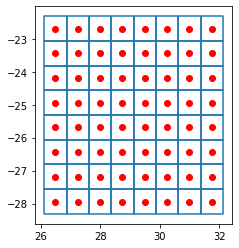

In [6]:
# Create rectangular grid for pixels corresponding to CAMS
bounds = list(cams_train_eop.bbox)
xres = (bounds[2]-bounds[0])/cams_train_eop.data["PM2_5"].shape[1]
yres = (bounds[3]-bounds[1])/cams_train_eop.data["PM2_5"].shape[2]
bounds = geometry.box(bounds[0], bounds[1], bounds[2], bounds[3])
bounds = gpd.GeoDataFrame(geometry=[bounds], crs="EPSG:4326")
CAMS_grid = recpolygrid(bounds, xres, yres, 4326)
CAMS_centroids = gpd.GeoDataFrame(geometry= CAMS_grid.centroid)
p = CAMS_grid.boundary.plot()
CAMS_centroids.plot(ax=p, color='red')
plt.show()

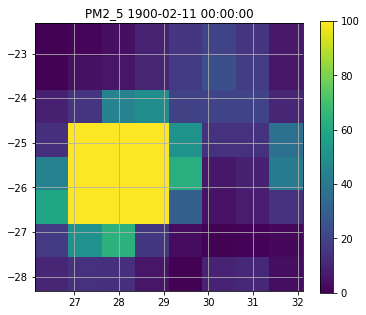

In [7]:
# Draw a sample
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=cams_train_eop, 
                 feature=(FeatureType.DATA, 'PM2_5'), 
                 time_idx=8, 
                 vmin=0, vmax=100)
fig.colorbar(fh, ax=ax);

### DEM

In [8]:
# Resampling DEM to 1 Km with the same bounding box of CAMS to make it manageable. Use custom function to use mean.

# Get resampling dimensions
target_size = bbox_to_dimensions(cams_train_eop.bbox, 1000)

# Sampling files to 40 km using bilinear interpolaiton
path_in = str(DATA_DIR/AOIS[0])+'/DEM/COP_DSM_south_africa_GLO-30.tif'
path_out = str(DATA_DIR/AOIS[0])+'/DEM/DEM_1km.tif'
upscale_mean_tiff(path_in, path_out, target_size)

In [9]:
# Read resampled DEM at 1 km
no_data_value = 128
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                              feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                              filename='DEM_1km.tif',
                              no_data_value=no_data_value)

## FILTER NO VALID DATA BEFORE STARTING
dem_train_eop.data_timeless['DEM'][dem_train_eop.data_timeless['DEM'] == no_data_value] = np.nan
    
# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0] # Remove one dimension
dem_grid = CAMS_grid
zstats = zonal_stats(dem_grid, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
dem_grid['elevation'] = vals

C:\Users\carle\Anaconda3\lib\site-packages\rasterstats\io.py:157: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  w, s = (col_start, row_stop) * affine
C:\Users\carle\Anaconda3\lib\site-packages\rasterstats\io.py:158: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  e, n = (col_stop, row_start) * affine


In [10]:
# Now we can rasterize
minx, miny, maxx, maxy = CAMS_grid.geometry.total_bounds
sizey = round((maxy-miny)/yres)
sizex = round((maxx-minx)/xres)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid.geometry, dem_grid['elevation']))
dem = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
dem
export_geotiff(str(dem_train_dir) + '/DEM_CAMS.tif', dem, transform, 4326)

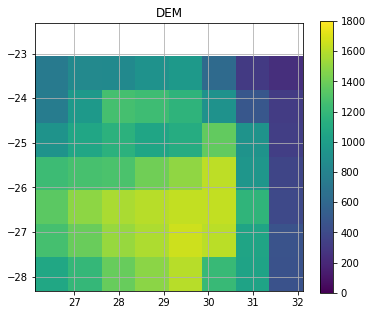

In [11]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                           filename='DEM_CAMS.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop, 
                 feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                 time_idx=None, 
                 vmin=0, vmax=1800)
fig.colorbar(fh, ax=ax);

### Prepare ERA5

In [25]:
## Select the temporal data of ERA5, the same of CAMS
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

hours = ['h00','h03','h06','h09','h15','h18','h21','h23']
era5_products = ['relative_humidity', 'specific_rain_water_content', 'wind_u', 'wind_v']
files_name = []
for era5_p in era5_products:
    era5_product_paths = []
    for hour in hours:
        era5_product_path = glob.glob(str(era5_train_dir) +'/' +era5_p + '/' +  f'*{hour}.tif')[0:2208]
        era5_product_paths = era5_product_paths + era5_product_path
        filenames = [path.replace(str(era5_train_dir) + f'/{era5_p}/','') for path in era5_product_paths]
        
    files_name.append(filenames)

In [26]:
## Load ERA5
# Prepare directory and product list
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

# Load data
era5_eops = []
for file_names, era5_p in [(files_name[0], 'relative_humidity'),(files_name[1], 'specific_rain_water_content'),(files_name[2], 'wind_u'),(files_name[3], 'wind_v')]:
    era5_eop = load_list_tiffs(era5_train_dir/era5_p, 
                               (FeatureType.DATA,era5_p), 
                                offset=OFFSET,
                                filename = file_names,
                                image_dtype=np.float32,
                                data_source='era5')
    era5_eops.append(era5_eop)



# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': era5_eops[2].data['wind_u'],
                        'wind_v': era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': era5_eops[1].meta_info['Names'],
                             'Names_wind_u': era5_eops[2].meta_info['Names'],
                             'Names_wind_v': era5_eops[3].meta_info['Names']},
                     timestamp=era5_eops[0].timestamp,
                     bbox=era5_eops[0].bbox)
del era5_eops
era5_eop

ResourceNotFound: resource 'Users/carle/Documents/ai4eo/air_quality/training_dataset_south_africa/South_Africa/era5/relative_humidity/training_dataset_south_africa/South_Africa/era5/relative_humidity/ERA5_rh_day2141_h00.tif' not found

In [22]:
## Filter NO VALID DATA OF ERA5
NO_DATA_VALUE = -32767

era5_eop.data['relative_humidity'][era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
era5_eop.data['specific_rain_water_content'][era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_u'][era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_v'][era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

NameError: name 'era5_eop' is not defined

In [14]:

# Perform zonal statistics - ERA5 products per CAMS pixel
# Rastrize the new CAMS zonal stats and save them on disk

era5_location=  str(DATA_DIR/AOIS[0])+'/era5'

## location of exported tiff (ERA5 matching CAMS grid)
era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'
if not os.path.isdir(era5_cams_location):
    os.makedirs(era5_cams_location)
    for i in era5_products:
        os.mkdir(era5_cams_location + '/' + i)
        
for index, era5p in enumerate(era5_products):
    tiffs = sorted(files_name[index])
    i=0
    for tiff in tiffs:
        for era5_path in glob.glob(str(era5_location) + '/' + era5p + '/' +  tiff):
            src = rio.open(era5_path)
            affine = src.transform
            array = era5_eop.data[era5p][i]
            array = array[:, :, 0]
            era5_grid = CAMS_grid
            era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)

            vals = []
            for index, value in enumerate(era5_stats):
                vals.append(value['mean'])

            era5_grid[era5p] = vals

            # rasterize
            minx, miny, maxx, maxy = CAMS_grid.geometry.total_bounds
            sizey = round((maxy-miny)/yres)
            sizex = round((maxx-minx)/xres)

            transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
            shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5p]))
            era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
            tiffname = era5_eop.meta_info['Names_'+ era5p][i]
            export_geotiff(str(era5_cams_location) + '/' +era5p + '/'+ tiffname, era5, transform, 4326)
            
            i+=1

del era5_eop

In [15]:
## Read rastraized ERA5 

# Prepare directory and product list
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'
ras_era5_location=Path(era5_cams_location)

# Load data
ras_era5_eops = [load_tiffs(ras_era5_location/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]



# Merge into one EOPS
ras_era5_eop = EOPatch(data={'relative_humidity': ras_era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': ras_era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': ras_era5_eops[2].data['wind_u'],
                              'wind_v': ras_era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': ras_era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':ras_era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': ras_era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': ras_era5_eops[3].meta_info['Names']},
                        timestamp= ras_era5_eops[0].timestamp,
                        bbox= ras_era5_eops[0].bbox)

del ras_era5_eops

EOPatch(
  data: {
    relative_humidity: numpy.ndarray(shape=(736, 8, 8, 1), dtype=float32)
    specific_rain_water_content: numpy.ndarray(shape=(736, 8, 8, 1), dtype=float32)
    wind_u: numpy.ndarray(shape=(736, 8, 8, 1), dtype=float32)
    wind_v: numpy.ndarray(shape=(736, 8, 8, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_relative_humidity: ['ERA5_rh_day2141_h00.tif', ..., 'ERA5_rh_day2232_h23.tif'], length=736
    Names_specific_rain_water_content: ['ERA5_srwc_day2141_h00.tif', ..., 'ERA5_srwc_day2232_h23.tif'], length=736
    Names_wind_u: ['ERA5_u_day2141_h00.tif', ..., 'ERA5_u_day2232_h23.tif'], length=736
    Names_wind_v: ['ERA5_v_day2141_h00.tif', ..., 'ERA5_v_day2232_h23.tif'], length=736
  }
  bbox: BBox(((26.125, -28.315000534057617), (32.125, -22.315000534057617)), crs=CRS('4326'))
  timestamp: [datetime.datetime(19

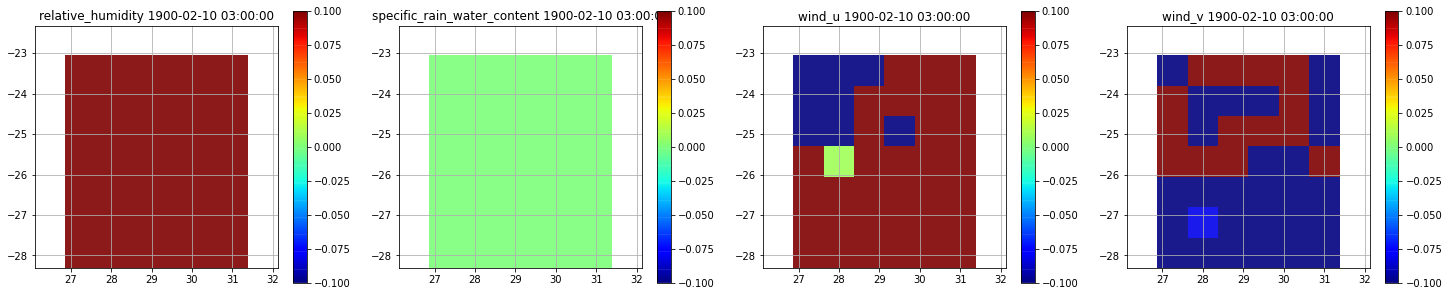

In [17]:
## plot rastraized ERA5

fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 1

normalisations = [dict(vmin=np.min(ras_era5_eop.data[era5_p]), 
                       vmax=np.max(ras_era5_eop.data[era5_p])) 
                  for era5_p in era5_products]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=ras_era5_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### Land cover

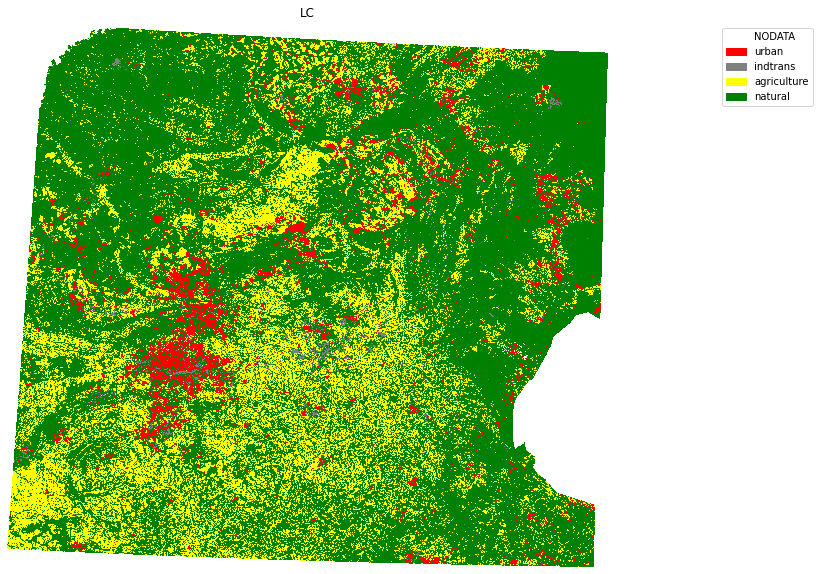

In [10]:
# Read data (CRS: 4326)
land_cover_train_dir = DATA_DIR/AOIS[0]/'Land_cover'
txt_filename = land_cover_train_dir/'Legend.csv'
land_cover_eop = load_tiffs(datapath=land_cover_train_dir,
                            feature=(FeatureType.MASK_TIMELESS, 'LC'), 
                            filename='SANLC_2018_africa.tif',
                            image_dtype=np.uint8,
                            no_data_value=0)

# Reclassify values
array = land_cover_eop.mask_timeless['LC']
land_cover_eop.mask_timeless['LC'][np.isin(array, list(range(1,32)))] = 4 # Natural
land_cover_eop.mask_timeless['LC'][np.isin(array, list(range(32,47)))] = 3 # Agriculture
land_cover_eop.mask_timeless['LC'][np.isin(array, list(range(47,66)))] = 1 # Urban
land_cover_eop.mask_timeless['LC'][np.isin(array, list(range(66,74)))] = 2 # Industrial, roads, rail, mines, landfills

# Define the colors you want
cmap = ListedColormap(["white", "red", "grey", "yellow", "green"])

# Add a legend for labels
legend_labels = {"white": "NODATA", 
                 "red": "urban",
                 "grey": "indtrans",
                 "yellow": "agriculture",
                 "green": "natural"             
                 }

# Create patches
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

fig, ax = plt.subplots(figsize=(15,10))

fh = draw_feature(ax=ax, eopatch=land_cover_eop, 
                  feature=(FeatureType.MASK_TIMELESS, 'LC'), 
                  time_idx=None, 
                  cmap=cmap,
                  vmin=0, vmax=4)
ax.legend(handles=patches,
          bbox_to_anchor=(1.35, 1),
          facecolor="white")
ax.set_axis_off()
plt.show()

In [12]:
# Zonal statistics
src = rio.open(str(land_cover_train_dir) + '/SANLC_2018_africa.tif')
affine = src.transform
array = land_cover_eop.mask_timeless['LC']
array = array[:, :, 0] # Remove one dimension
zstats = zonal_stats(CAMS_grid, array, affine=affine, stats="count", categorical=True)

# Generate percentage indicators
urban = []
indtrans = []
agri = []
natural = []
urban, indtrans, agri, natural = percs_landuse(zstats, urban, indtrans, agri, natural)

C:\Users\carle\Anaconda3\lib\site-packages\rasterstats\io.py:157: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  w, s = (col_start, row_stop) * affine
C:\Users\carle\Anaconda3\lib\site-packages\rasterstats\io.py:158: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  e, n = (col_stop, row_start) * affine
C:\Users\carle\Anaconda3\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


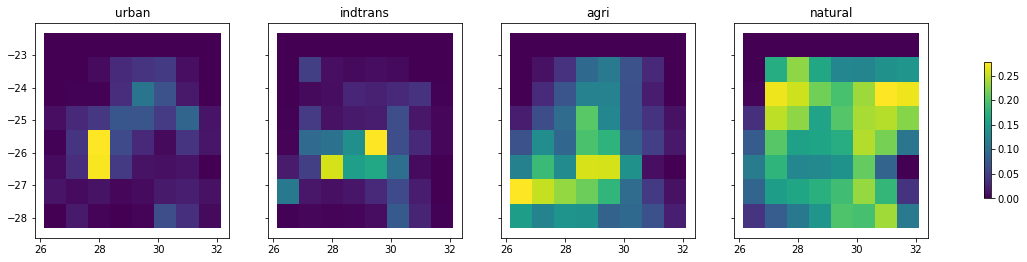

In [13]:
# Add to grid object
LC_grid = CAMS_grid
LC_grid['urban'] = urban
LC_grid['indtrans'] = indtrans
LC_grid['agri'] = agri
LC_grid['natural'] = natural

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20,5))
LC_grid.plot(ax=axs[0], column='urban')
axs[0].set_title('urban')
LC_grid.plot(ax=axs[1], column='indtrans')
axs[1].set_title('indtrans')
LC_grid.plot(ax=axs[2], column='agri')
axs[2].set_title('agri')
LC_grid.plot(ax=axs[3], column='natural')
axs[3].set_title('natural')
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.5)

In [14]:
# Rasterize
minx, miny, maxx, maxy = LC_grid.geometry.total_bounds
sizey = round((maxy-miny)/yres)
sizex = round((maxx-minx)/xres)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
for lc_class in ['urban', 'indtrans', 'agri', 'natural']:
    shapes = ((geom, value) for geom, value in zip(LC_grid.geometry, LC_grid[lc_class]))
    lc = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    export_geotiff(str(land_cover_train_dir) + '/LC_CAMS_' + lc_class + '.tif', lc, transform, 4326)

# Data merging

Now that everything is in the same format, we need to create our training datasets to start modelling.

In [31]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
if preproc:
    raster_path = [(str(dem_train_dir) + '/DEM_CAMS.tif')]
    dem_df = extract_points_from_raster(CAMS_centroids, raster_path, 'DEM')
    dem_df = pd.concat(dem_df)
    dem_df = dem_df.dropna()
    dem_df = dem_df.drop('raster', 1)

In [56]:
# Extract land use
LC_path = glob.glob(str(land_cover_train_dir) + '/LC_CAMS_urban.tif')
LC_df = extract_points_from_raster(CAMS_centroids, [LC_path[0]], 'urban')
LC_df = pd.concat(LC_df)
LC_df = LC_df.dropna()
LC_df = LC_df.drop('raster', 1)
for LC_class in ['indtrans', 'agri', 'natural']:
    LC_path = glob.glob(str(land_cover_train_dir) + '/LC_CAMS_' + LC_class + '.tif')
    LC_df2 = extract_points_from_raster(CAMS_centroids, [LC_path[0]], LC_class)
    LC_df2 = pd.concat(LC_df2)
    LC_df2 = LC_df2.dropna()
    LC_df2 = LC_df2.drop('raster', 1)
    LC_df = pd.merge(LC_df, LC_df2, on=['lon', 'lat'], how='inner')

In [20]:
# Extract CAMS
cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'
CAMS_paths = glob.glob(str(cams_train_dir) + '/PM2_5/*.tif')[0:736]
CAMS_df = extract_points_from_raster(CAMS_centroids, CAMS_paths, 'CAMS')
CAMS_df = pd.concat(CAMS_df)
CAMS_df = CAMS_df.dropna()
CAMS_df = CAMS_df.drop(CAMS_df[CAMS_df.CAMS==-999].index)

In [24]:
# Extract ERA5
ras_era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'

## We can put this function in the utility file
def extract_era5(era5_p,cams_centroids,path):
    era5_paths = glob.glob(str(path) + '/'+ era5_p +'/*.tif')[0:736]
    era5_df = extract_points_from_raster(cams_centroids, era5_paths, era5_p)
    era5_df = pd.concat(era5_df)
    era5_df = era5_df.dropna()
    return era5_df

relative_humidity_df = extract_era5('relative_humidity', CAMS_centroids, ras_era5_cams_location)
specific_rain_water_content_df = extract_era5('specific_rain_water_content', CAMS_centroids, ras_era5_cams_location)
wind_u_df = extract_era5('wind_u', CAMS_centroids, ras_era5_cams_location)
wind_v_df = extract_era5('wind_v', CAMS_centroids, ras_era5_cams_location)

In [26]:
## Extract the tiff names
CAMS_df['raster'] = CAMS_df['raster'].replace(str(cams_train_dir) + '/PM2_5/','',regex=True)
for era5_p, name in [(relative_humidity_df,'relative_humidity'),(specific_rain_water_content_df,'specific_rain_water_content'),(wind_u_df,'wind_u'),(wind_v_df,'wind_v')]:
    era5_p['raster'] = era5_p['raster'].replace(str(ras_era5_cams_location) + '/' + name + '/','',regex=True)

In [27]:
### Extract the day and time of observations 

day_hour_df=[CAMS_df,relative_humidity_df,specific_rain_water_content_df,wind_u_df,wind_v_df]
for df in day_hour_df:
    df['day']=np.nan
    df['hour']=np.nan
    df['dayhour']=""
    for i in range(df.shape[0]):
        tiff_name = df.iloc[i]['raster']
        day, hour = tiff_name.split('_day')[-1].split('_')
        
        df.iat[i,df.columns.get_loc('day')] = day
        df.iat[i,df.columns.get_loc('hour')] = hour[1:3]
        df.iat[i,df.columns.get_loc('dayhour')] = str(day)+str(hour[1:3])
        
CAMS_df = CAMS_df.drop('raster', 1)
relative_humidity_df = relative_humidity_df.drop('raster', 1)
specific_rain_water_content_df = specific_rain_water_content_df.drop('raster', 1)
wind_u_df = wind_u_df.drop('raster', 1)
wind_v_df = wind_v_df.drop('raster', 1)

In [28]:
# write to disk each data frame

for df,name in [(CAMS_df,'CAMS_df.csv'),(relative_humidity_df,'relative_humidity_df.csv'),(specific_rain_water_content_df,'specific_rain_water_content_df.csv'),(wind_u_df,'wind_u_df.csv'),(wind_v_df,'wind_v_df.csv')]:
    df.to_csv(str(DATA_DIR) + '/'+name)

In [29]:
# Inner join by time & coordinates (CAMS & ERA5)
train_df = pd.merge(CAMS_df, relative_humidity_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, specific_rain_water_content_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_u_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_v_df, on=['day','hour','lon', 'lat'], how='inner')

# Inner join by coordinates
train_df = pd.merge(train_df, dem_df, on=['lon', 'lat'], how='inner')
train_df = pd.merge(train_df, LC_df, on=['lon', 'lat'], how='inner')

# write to disk
train_df.to_csv(str(DATA_DIR) + '/training_data_dem_era5.csv')

In [5]:
# Read data
train_df = pd.read_csv(str(DATA_DIR) + '/training_data_dem_era5.csv', index_col=0)

## Exploratory analysis

Summary statistics:

In [6]:
train_df.describe()

,lon,lat,CAMS,day,hour,dayhour_x,relative_humidity,dayhour_y,specific_rain_water_content,dayhour_x.1,wind_u,dayhour_y.1,wind_v,dayhour,DEM
count,27048.000000,27048.000000,2.704800e+04,27048.000000,27048.000000,27048.000000,27048.000000,27048.000000,2.704800e+04,27048.000000,27048.000000,27048.000000,27048.000000,27048.000000,27048.000000
mean,29.125000,-25.690001,5.597766e+01,2186.500000,10.285714,218660.285714,53.700159,218660.285714,3.026995e-07,218660.285714,-0.077465,218660.285714,-0.410684,218660.285714,1218.480637
std,1.280893,1.500028,7.896029e+01,26.557034,7.323567,2655.713536,21.858531,2655.713536,2.152374e-06,2655.713536,1.913170,2655.713536,1.607557,2655.713536,324.932709
min,27.250000,-27.940001,-1.058791e-13,2141.000000,0.000000,214100.000000,4.659235,214100.000000,0.000000e+00,214100.000000,-7.526741,214100.000000,-8.252639,214100.000000,306.318828
25%,28.000000,-27.190001,1.439677e+01,2163.750000,3.000000,216380.250000,35.934128,216380.250000,0.000000e+00,216380.250000,-1.449791,216380.250000,-1.420420,216380.250000,975.806744
50%,29.125000,-25.690001,3.049453e+01,2186.500000,9.000000,218660.500000,51.836478,218660.500000,0.000000e+00,218660.500000,-0.160665,218660.500000,-0.398250,218660.500000,1228.195956
75%,30.250000,-24.190001,6.113697e+01,2209.250000,18.000000,220940.750000,70.963043,220940.750000,0.000000e+00,220940.750000,1.256697,220940.750000,0.607153,220940.750000,1499.884498
max,31.000000,-23.440001,1.615520e+03,2232.000000,21.000000,223221.000000,100.399574,223221.000000,7.054788e-05,223221.000000,8.633376,223221.000000,6.588699,223221.000000,1663.530354


Association of CAMS with DEM:

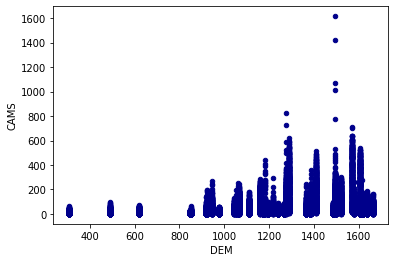

In [44]:
ax1 = train_df.plot.scatter(x='DEM', y='CAMS', c='DarkBlue')

Association of CAMS with lon:

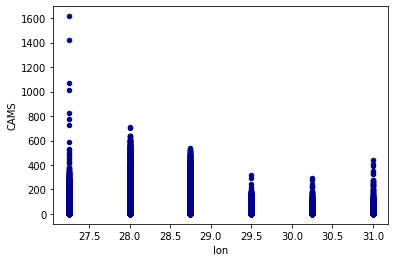

In [32]:
ax2 = train_df.plot.scatter(x='lon', y='CAMS', c='DarkBlue')

Association of CAMS with lat:

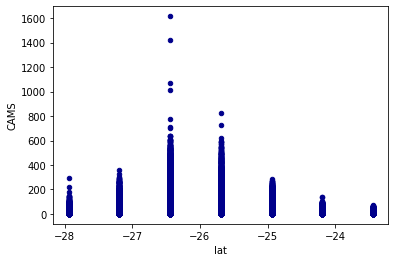

In [33]:
ax3 = train_df.plot.scatter(x='lat', y='CAMS', c='DarkBlue')

Association of CAMS with hour:

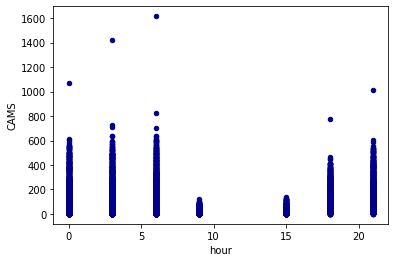

In [34]:
ax4 = train_df.plot.scatter(x='hour', y='CAMS', c='DarkBlue')

Association of CAMS with date:

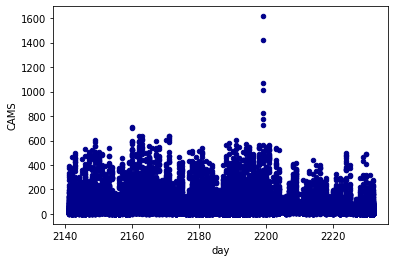

In [36]:
ax5 = train_df.plot.scatter(x='day', y='CAMS', c='DarkBlue')

Association of CAMS with relative_humidity:

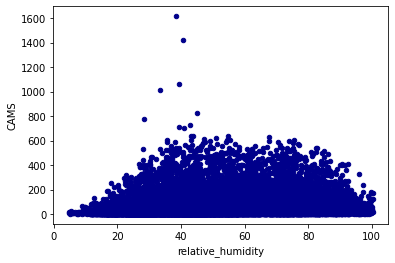

In [7]:
ax6 = train_df.plot.scatter(x='relative_humidity', y='CAMS', c='DarkBlue')

Association of CAMS with specific_rain_water_content:

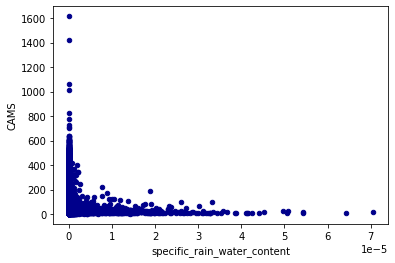

In [8]:
ax7 = train_df.plot.scatter(x='specific_rain_water_content', y='CAMS', c='DarkBlue')

Association of CAMS with wind_u:

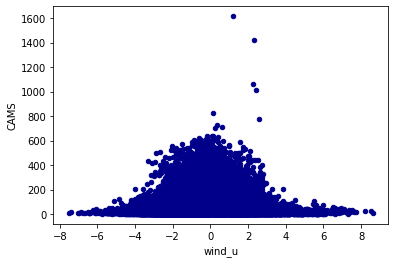

In [9]:
ax8 = train_df.plot.scatter(x='wind_u', y='CAMS', c='DarkBlue')

Association of CAMS with wind_v:

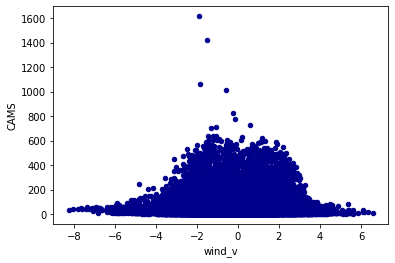

In [10]:
ax9 = train_df.plot.scatter(x='wind_v', y='CAMS', c='DarkBlue')

In [11]:
train_df

,lon,lat,CAMS,day,hour,dayhour_x,relative_humidity,dayhour_y,specific_rain_water_content,dayhour_x.1,wind_u,dayhour_y.1,wind_v,dayhour,DEM
0,27.25,-23.440001,12.745087,2141.0,0.0,214100,78.068685,214100,0.0,214100,-0.804597,214100,1.171631,214100,847.243533
1,27.25,-23.440001,16.393583,2141.0,3.0,214103,77.721987,214103,0.0,214103,-1.538880,214103,-0.511131,214103,847.243533
2,27.25,-23.440001,17.552229,2141.0,6.0,214106,75.781603,214106,0.0,214106,-0.609182,214106,-0.350456,214106,847.243533
3,27.25,-23.440001,13.509299,2141.0,9.0,214109,51.231837,214109,0.0,214109,0.907805,214109,1.200632,214109,847.243533
4,27.25,-23.440001,4.782489,2141.0,15.0,214115,41.198568,214115,0.0,214115,1.159037,214115,1.194687,214115,847.243533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,31.00,-27.940001,81.425575,2232.0,6.0,223206,53.725803,223206,0.0,223206,1.506995,223206,-0.489876,223206,1045.173623
27044,31.00,-27.940001,24.306879,2232.0,9.0,223209,23.474244,223209,0.0,223209,0.725448,223209,-0.991894,223209,1045.173623
27045,31.00,-27.940001,10.846883,2232.0,15.0,223215,33.764412,223215,0.0,223215,-1.955020,223215,-2.531453,223215,1045.173623
27046,31.00,-27.940001,26.993946,2232.0,18.0,223218,49.477308,223218,0.0,223218,-0.181254,223218,-2.531994,223218,1045.173623


Rank correlation between predictors

In [12]:
# calculate the correlation matrix
corr = train_df.drop(['dayhour_x','dayhour_y','dayhour','dayhour_x.1','dayhour_y.1'], axis=1).corr(method='spearman')
round(corr, 2)

,lon,lat,CAMS,day,hour,relative_humidity,specific_rain_water_content,wind_u,wind_v,DEM
lon,1.00,0.00,-0.15,0.00,0.00,0.27,0.22,0.12,0.12,-0.17
lat,0.00,1.00,-0.27,0.00,0.00,-0.00,-0.05,-0.28,0.10,-0.66
CAMS,-0.15,-0.27,1.00,-0.04,-0.10,0.18,-0.05,0.10,-0.01,0.33
day,0.00,0.00,-0.04,1.00,0.00,-0.12,0.13,-0.05,-0.29,0.00
hour,0.00,0.00,-0.10,0.00,1.00,-0.35,-0.11,-0.03,-0.08,0.00
relative_humidity,0.27,-0.00,0.18,-0.12,-0.35,1.00,0.48,-0.28,0.09,-0.07
specific_rain_water_content,0.22,-0.05,-0.05,0.13,-0.11,0.48,1.00,-0.23,0.05,-0.02
wind_u,0.12,-0.28,0.10,-0.05,-0.03,-0.28,-0.23,1.00,-0.03,0.22
wind_v,0.12,0.10,-0.01,-0.29,-0.08,0.09,0.05,-0.03,1.00,-0.12
DEM,-0.17,-0.66,0.33,0.00,0.00,-0.07,-0.02,0.22,-0.12,1.00


## Modelling

Very simple RF model as a starting point. WARNING! MODELS STILL NEED TO BE TUNED!!

In [13]:
# X and Y parts
train_X = np.array(train_df.drop(['CAMS','day','dayhour_x','dayhour_y','dayhour','dayhour_x.1','dayhour_y.1'], axis=1))
train_y = np.array(train_df['CAMS'])

In [14]:
# Random Forest Regression.
rf = RandomForestRegressor(n_estimators = 100) # Let's make it quick for now
# Train the model on training data
rf.fit(train_X, train_y)
pred_y = rf.predict(train_X)

In [15]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(train_df.drop(['CAMS','day','dayhour_x','dayhour_y','dayhour','dayhour_x.1','dayhour_y.1'], axis=1).columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hour                 Importance: 0.21
Variable: lat                  Importance: 0.18
Variable: wind_v               Importance: 0.15
Variable: lon                  Importance: 0.14
Variable: DEM                  Importance: 0.13
Variable: wind_u               Importance: 0.12
Variable: relative_humidity    Importance: 0.07
Variable: specific_rain_water_content Importance: 0.0


Resubsitution error:

Resubstitution MAE: 6.24
Resubstitution RMSE: 12.53
Resubstitution R2: 0.975


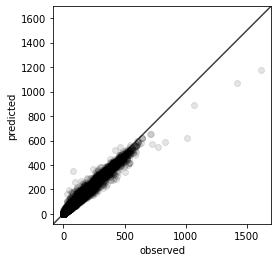

In [16]:
# Resubstitution error
print('Resubstitution MAE:', round(metrics.mean_absolute_error(train_y, pred_y), 2))
print('Resubstitution RMSE:', round(np.sqrt(metrics.mean_squared_error(train_y, pred_y)), 2))
print('Resubstitution R2:', round(metrics.r2_score(train_y, pred_y), 3))

fig, ax = plt.subplots()
ax.scatter(train_y, pred_y, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

Cross-validated error:

In [56]:
# Cross-validated error (each daytime in a separate fold to emulate a new observation)
groups = np.array(train_df['dayhour'])
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(train_X, train_y, groups)

alltest_CV = np.empty((0,1), float)
allpreds_CV = np.empty((0,1), float)
allindx_CV = np.empty((0,1), float)

MAE_CV=[]
RMSE_CV=[]
R2_CV=[]
for train_index, test_index in group_kfold.split(train_X, train_y, groups):
    train_X_CV, test_X_CV = train_X[train_index], train_X[test_index]
    train_y_CV, test_y_CV = train_y[train_index], train_y[test_index]
    rf.fit(train_X_CV, train_y_CV)
    pred_y_CV = rf.predict(test_X_CV)
    alltest_CV = np.append(alltest_CV, test_y_CV)
    allpreds_CV = np.append(allpreds_CV, pred_y_CV)
    allindx_CV =  np.append(allindx_CV, train_index)
    MAE_CV.append(round(metrics.mean_absolute_error(test_y_CV, pred_y_CV), 2))
    RMSE_CV.append(round(np.sqrt(metrics.mean_squared_error(test_y_CV, pred_y_CV)), 2))
    R2_CV.append(round(metrics.r2_score(test_y_CV, pred_y_CV), 3))

CV MAE: 17.46
CV RMSE: 34.65
CV R2: 0.8


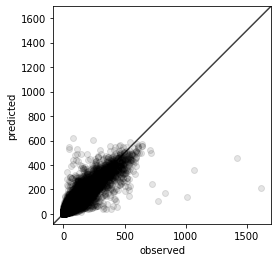

In [57]:
# Metrics
print('CV MAE:', round(statistics.mean(MAE_CV), 2))
print('CV RMSE:', round(statistics.mean(RMSE_CV), 2))
print('CV R2:', round(statistics.mean(R2_CV), 2))

fig, ax = plt.subplots()
ax.scatter(alltest_CV, allpreds_CV, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()